#### Kramers-Kronig calculation to predict refractive index over the full wavelength spectrum

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
from matplotlib.ticker import MaxNLocator

Workflow:  
- Import full spectrum absorbance data
- Calculate absorption coefficient and imaginary part of RI
- Set reference RI (starting point) as the predicted RI (from prediction model) at a specific concentration
- Run the kramers-kronig calculation

In [16]:
def abs_coefficient(absorbance, 
                    used_conc, 
                    predict_conc):
    """ Calculate the absorption coefficient using Beer's law with the measured 
        absorbance, the concentration used in measurement, and the desired 
        concentration for prediction. """
    
    e = absorbance / used_conc  # Molar absorptivity
    alpha = e * predict_conc    # Absorption coefficient

    return alpha

In [18]:
def kramers_kronig(compound_name,
                   conc,
                   wavelengths,
                   abs_coeff,
                   ref_ri,
                   y_min=1.32,
                   y_max=1.55):
    """ Predict refractive index over the full spectrum using the Kramers-Kronig relation.
        Input the compound's name and molar concentration, wavelengths, absorption coefficient, 
        ref_ri - predicted RI using prediction model. If the RI range is bigger than 1.32 - 1.52,
        manually set y_min= and y_max= for y_axis. """
    
    # Compute imaginary part of RI
    k = (abs_coeff * (wavelengths * 1e-7)) / (4 * np.pi)
    
    ri_values = []
    
    # Iterate over the full wavelength spectrum, treating each point as the target
    for target_lambda in wavelengths:

        # Unit conversion (nm to m)
        wavelengths_m = wavelengths * 1e-9
        target_lambda = target_lambda * 1e-9
        
        # Eliminate point where denominator is 0 (where lambda' = lambda)
        limit = ~np.isclose(wavelengths_m, target_lambda)
        k_valid = k[limit]
        alpha_valid = abs_coeff[limit]
        wavelengths_valid = wavelengths_m[limit]

        # Set Kramers-Kronig integration variables
        denominator = wavelengths_valid * (1 - (wavelengths_valid**2 / target_lambda**2))

        # Set integrand
        integrand = k_valid / denominator

        # Perform integration using trapezoidal rule
        delta_n = (2 / np.pi) * np.trapz(integrand, wavelengths_valid)
        n = ref_ri + delta_n
        ri_values.append(n)
    
    # Plot the predict RI values and absorbance over the full spectrum
    fig, ax1 = plt.subplots()

    # Plot RI
    ax1.plot(wavelengths, ri_values, "b-", label="RI")
    ax1.set_xlabel("Wavelengths (nm)")
    ax1.set_ylabel("Predicted refractive index", color="b")
    ax1.tick_params("y", colors="b")

    if y_min == 1.32 and y_max == 1.55:     # Default y-axis
        ax1.set_yticks(np.arange(y_min, y_max, 0.02))
    else:
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=10))
    

    # Plot absorbance
    ax2 = ax1.twinx()
    ax2.plot(wavelengths, abs_coeff, "r-", label="Abs")
    ax2.set_ylabel("Absorption coefficient", color="r")
    ax2.tick_params("y", colors="r")
    
    plt.title(f"Predicted RI and absorbance of {compound_name} ({conc})")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc = "upper right")

    plt.show()

#### Kramers-Kronig calculation to get the full RI spectrum

To import absorbance data to run Kramers-Kronig calculation, add the absorbance data file to the folder "data".

#### Tartrazine

In [19]:
# Read data from .txt file with measured absorbance data
ttz_abs = pd.read_csv("data/TTZ 10µM PBS abs.txt", sep="\t", header=None)

# Rename the columns in the data table
ttz_abs.columns = ["Wavelengths", "Abs"]

# Set the wavelengths limit - this can be changed to eliminate negative absorbance
ttz_abs = ttz_abs[300:2010]

ttz_abs

,Wavelengths,Abs
300,292.36,0.035
301,292.73,0.033
302,293.11,0.029
303,293.48,0.028
304,293.86,0.025
...,...,...
2005,871.55,-0.002
2006,871.85,-0.004
2007,872.15,-0.003
2008,872.45,-0.003


In [20]:
# Calculate absorption coefficient at each wavelength
abs_coeff = abs_coefficient(ttz_abs["Abs"], # Absorbance column from table
                            10 * 1e-6,  # Concentration used for measurement - 10 uM (convert to M)
                            1)  # Concentration for prediction (in M)

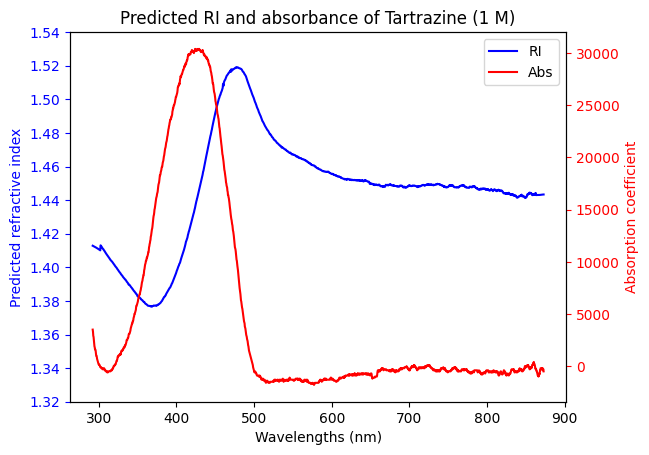

In [28]:
# Kramers-Kronig calculation

# Get the predicted RI using the XGBoost model at the specified concentration
ref_ri = 1.428

# Perform the integration to get full spectrum RI
ri_spectrum = kramers_kronig(compound_name = "Tartrazine",
                             conc = "1 M",
                             wavelengths = ttz_abs["Wavelengths"],
                             abs_coeff = abs_coeff,
                             ref_ri = ref_ri)

#### Methylene blue

In [13]:
# Read in data from .txt file (online source - PhotochemCAD)
mb_abs = pd.read_csv("data/MB abs.txt", sep="\t")
mb_abs.columns = ["Wavelengths", "Abs"]
mb_abs

,Wavelengths,Abs
0,200.0,5621.700
1,201.0,5737.000
2,202.0,5436.900
3,203.0,4929.500
4,204.0,4650.500
...,...,...
596,796.0,29.404
597,797.0,15.291
598,798.0,25.622
599,799.0,23.081


ValueError: x and y must have same first dimension, but have shapes (601,) and (1710,)

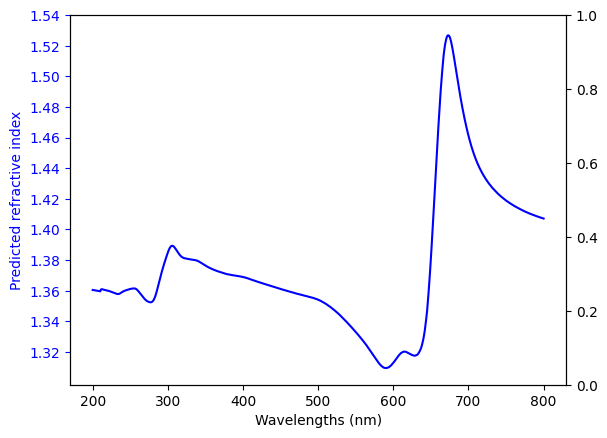

In [14]:
# In this case, the online source already provided absorbtion coefficient so 
# we can skip the function abs_coefficient

# Kramers-Kronig calculation

# Get the predicted RI using the XGBoost model at the specified concentration
ref_ri = 1.368

# Perform the integration to get full spectrum RI
ri_spectrum = kramers_kronig(mb_abs["Wavelengths"],
                             mb_abs["Abs"],
                             ref_ri)

# Plot the spectrum
plot_spectrum("Methylene blue",
              "1 M",
              mb_abs["Wavelengths"],
              abs_coeff,
              ri_spectrum)

#### Evans blue

In [ ]:
eb_abs = pd.read_csv("data/EB abs.txt", sep="\t")
eb_abs.columns = ["Wavelengths", "Abs"]
eb_abs

,Wavelengths,Abs
0,280.0,22161.000
1,281.0,21901.000
2,282.0,21673.000
3,283.0,21452.000
4,284.0,21253.000
...,...,...
516,796.0,54.836
517,797.0,62.908
518,798.0,55.497
519,799.0,59.179


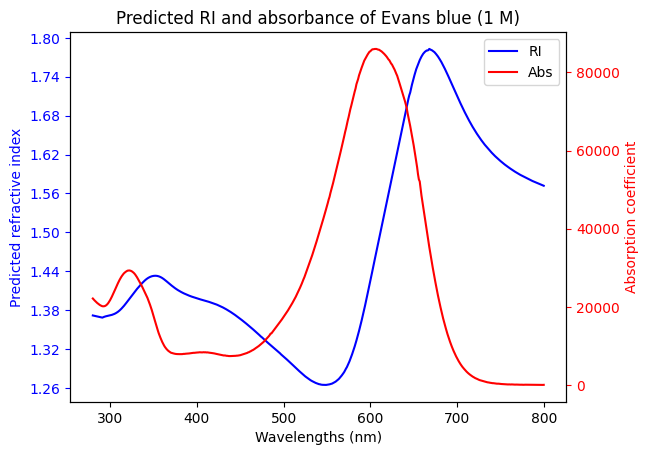

In [ ]:
# In this case, the online source already provided absorbtion coefficient so 
# we can skip the function abs_coefficient

# Kramers-Kronig calculation

# Get the predicted RI using the XGBoost model at the specified concentration
ref_ri = 1.423

# Perform the integration to get full spectrum RI
ri_spectrum = kramers_kronig(eb_abs["Wavelengths"],
                             eb_abs["Abs"],
                             ref_ri)

# Plot the spectrum
plot_spectrum("Evans blue",
              "1 M",
              eb_abs["Wavelengths"],
              eb_abs["Abs"],
              ri_spectrum,
              y_min=1.26,
              y_max=1.80)